# Rescheduling mit Tardiness (Summe)
> Planunghorizont Tag 0: 2 Tage
> Rescheduling des Tages 1

In [2]:
max_time = 60*30 # 1/2h

In [3]:
import time

In [4]:
from ortools.sat.python import cp_model
import pandas as pd
import numpy as np
import math

pd.set_option('display.max_rows', 20)

In [5]:
import utils.presenter as show
import utils.checker as check

import utils.schedule_interarrival as sit
import utils.scheduling_solver as ssv
import utils.rescheduling_solver_tardiness as rssv

from ProductionDaySimulation import ProductionDaySimulation

In [6]:
import utils.rolling_planning.init_jobs_times as rp_init
import utils.schedule_deadline as deadline_gen

In [7]:
df_instance = pd.read_csv("data/00_instance.csv")
df_instance

,Job,Operation,Machine,Processing Time
0,job 0,0,M0,29
1,job 0,1,M1,78
2,job 0,2,M2,9
3,job 0,3,M3,36
4,job 0,4,M4,49
...,...,...,...,...
95,job 9,5,M9,76
96,job 9,6,M5,47
97,job 9,7,M3,52
98,job 9,8,M4,90


In [8]:
df_jssp, df_arrivals = rp_init.init_jobs_with_arrivals(df_instance, 2,  u_b_mmax = 0.95)
df_jssp

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
375,Job_037,5,M9,76
376,Job_037,6,M5,47
377,Job_037,7,M3,52
378,Job_037,8,M4,90


In [9]:
# Arrival-Werte durchmischen (aber nicht verändern)
df_arrivals['Arrival'] = df_arrivals['Arrival'].sample(frac=1.0, random_state=42).reset_index(drop=True)
df_arrivals

,Job,Arrival
0,Job_000,2568.21
1,Job_001,2694.35
2,Job_002,233.63
3,Job_003,1123.32
4,Job_004,2334.99
...,...,...
33,Job_033,1354.37
34,Job_034,1523.42
35,Job_035,488.49
36,Job_036,1128.21


In [10]:
df_times = deadline_gen.get_times_df(df_jssp, df_arrivals, ssv.schedule_fcfs_with_arrivals, target_service=1.0)
df_times["Arrival"] = np.floor(df_times["Arrival"]).astype(int)
df_times["Deadline"] = np.ceil(df_times["Deadline"]).astype(int)
df_times

,Job,Arrival,Deadline
0,Job_000,2568,3492
1,Job_001,2694,3887
2,Job_002,233,1561
3,Job_003,1123,2654
4,Job_004,2334,3254
...,...,...,...
33,Job_033,1354,2885
34,Job_034,1523,2442
35,Job_035,488,1816
36,Job_036,1128,2052


## I) Complete Scheduling

In [12]:
starting_time = time.time()

# Scheduling
df_plan = ssv.solve_cp_jssp_sum_tardiness(df_jssp, df_times, msg=False, timeLimit=max_time, gapRel= 0.00)
df_plan

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan


Solver-Status         : OPTIMAL
Summe Tardiness        : 0.0
Best Objective Bound   : 0.0
Laufzeit               : 1.00 Sekunden

Scheduling-Dauer: 0 Minuten und 1.22 Sekunden.


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Tardiness
0,Job_017,0,0,924,M0,0,29,29,-895,0
1,Job_017,1,0,924,M1,29,78,107,-817,0
2,Job_017,2,0,924,M2,107,9,116,-808,0
3,Job_021,0,83,1411,M1,107,91,198,-1213,0
4,Job_017,3,0,924,M3,116,36,152,-772,0
...,...,...,...,...,...,...,...,...,...,...
375,Job_022,5,2794,4325,M8,3517,52,3569,-756,0
376,Job_022,6,2794,4325,M7,3569,85,3654,-671,0
377,Job_022,7,2794,4325,M3,3654,98,3752,-573,0
378,Job_022,8,2794,4325,M9,3752,22,3774,-551,0


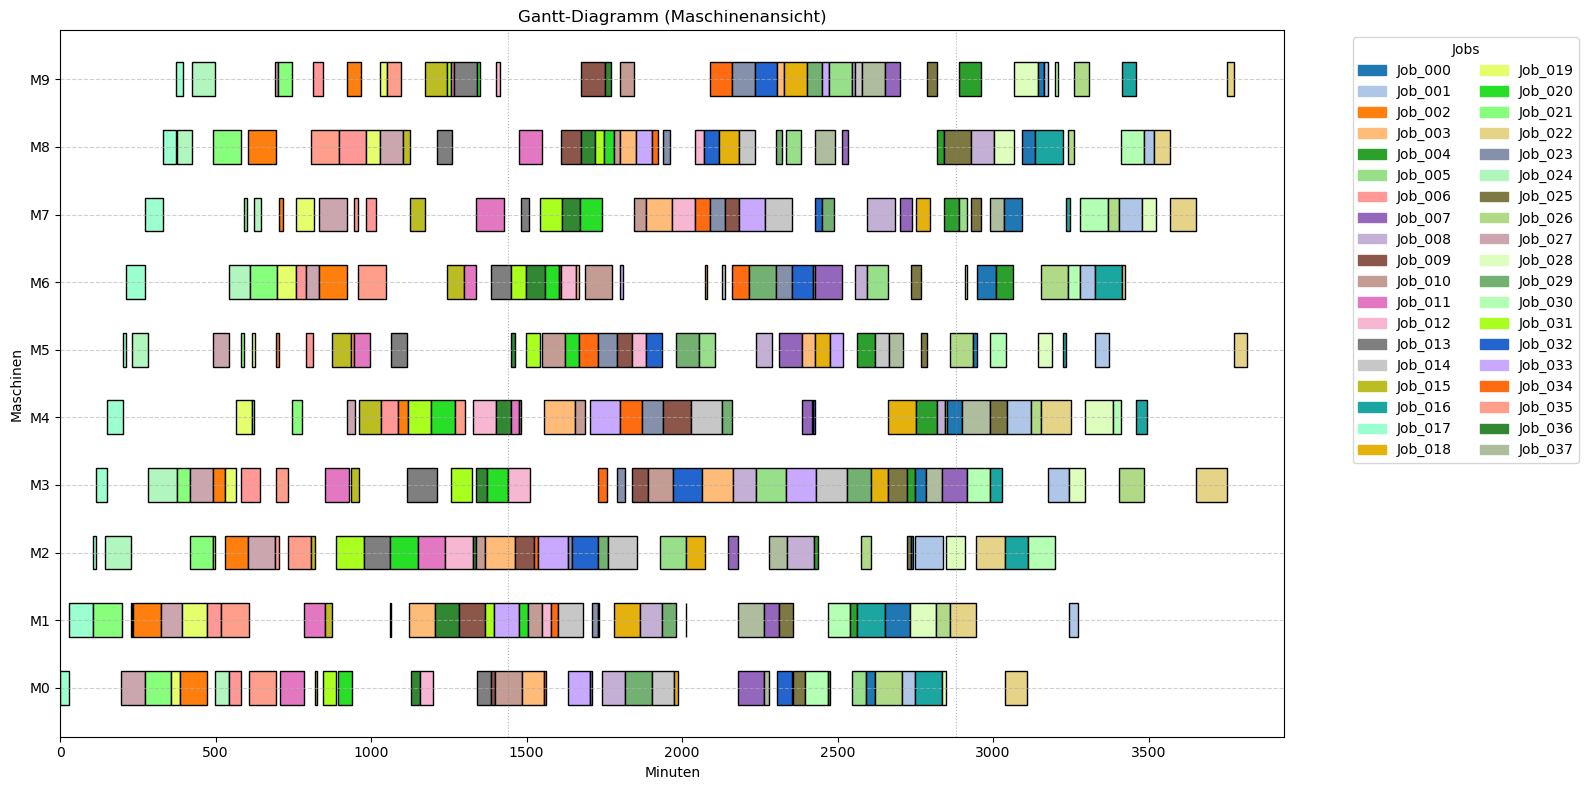

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job


True

In [13]:
show.plot_gantt_machines(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

## II) Erster Tag (Tag 0)

### a) Simulation

In [16]:
day_length = 1440

In [17]:
day_numb = 0

day_start = day_length*day_numb 
day_end = day_start + day_length

In [18]:
simulation = ProductionDaySimulation(df_plan, vc=0.35)
df_execution, df_undone = simulation.run(start_time = day_start, end_time=day_end)

[00:00:00] Job_017 started on M0
[00:58:40] Job_017 finished on M0 (after 58 minutes 41 seconds)
[00:58:40] Job_017 started on M1
[02:24:00] Job_024 started on M2
[02:45:54] Job_017 finished on M1 (after 107 minutes 13 seconds)
[02:45:54] Job_021 started on M1
[03:17:00] Job_027 started on M0
[03:48:39] Job_021 finished on M1 (after 62 minutes 46 seconds)
[03:53:00] Job_002 started on M1
[03:59:42] Job_024 finished on M2 (after 95 minutes 43 seconds)
[03:59:42] Job_017 started on M2
[04:13:05] Job_017 finished on M2 (after 13 minutes 23 seconds)
[04:13:05] Job_017 started on M3
[04:34:26] Job_002 finished on M1 (after 41 minutes 26 seconds)
[04:34:26] Job_024 started on M1
[04:37:02] Job_024 finished on M1 (after 02 minutes 36 seconds)
[04:37:02] Job_024 started on M5
[04:42:52] Job_017 finished on M3 (after 29 minutes 47 seconds)
[04:42:52] Job_017 started on M4
[05:01:50] Job_027 finished on M0 (after 104 minutes 50 seconds)
[05:01:50] Job_021 started on M0
[05:24:00] Job_027 started

In [19]:
df_undone

,Job,Operation,Arrival,Machine,Planned Start,Processing Time
0,Job_012,2,1135,M4,1327,75
1,Job_020,4,894,M3,1372,69
2,Job_012,3,1135,M9,1402,11
3,Job_036,4,1128,M4,1402,49
4,Job_012,4,1135,M3,1441,69
...,...,...,...,...,...,...
246,Job_022,5,2794,M8,3517,52
247,Job_022,6,2794,M7,3569,85
248,Job_022,7,2794,M3,3654,98
249,Job_022,8,2794,M9,3752,22


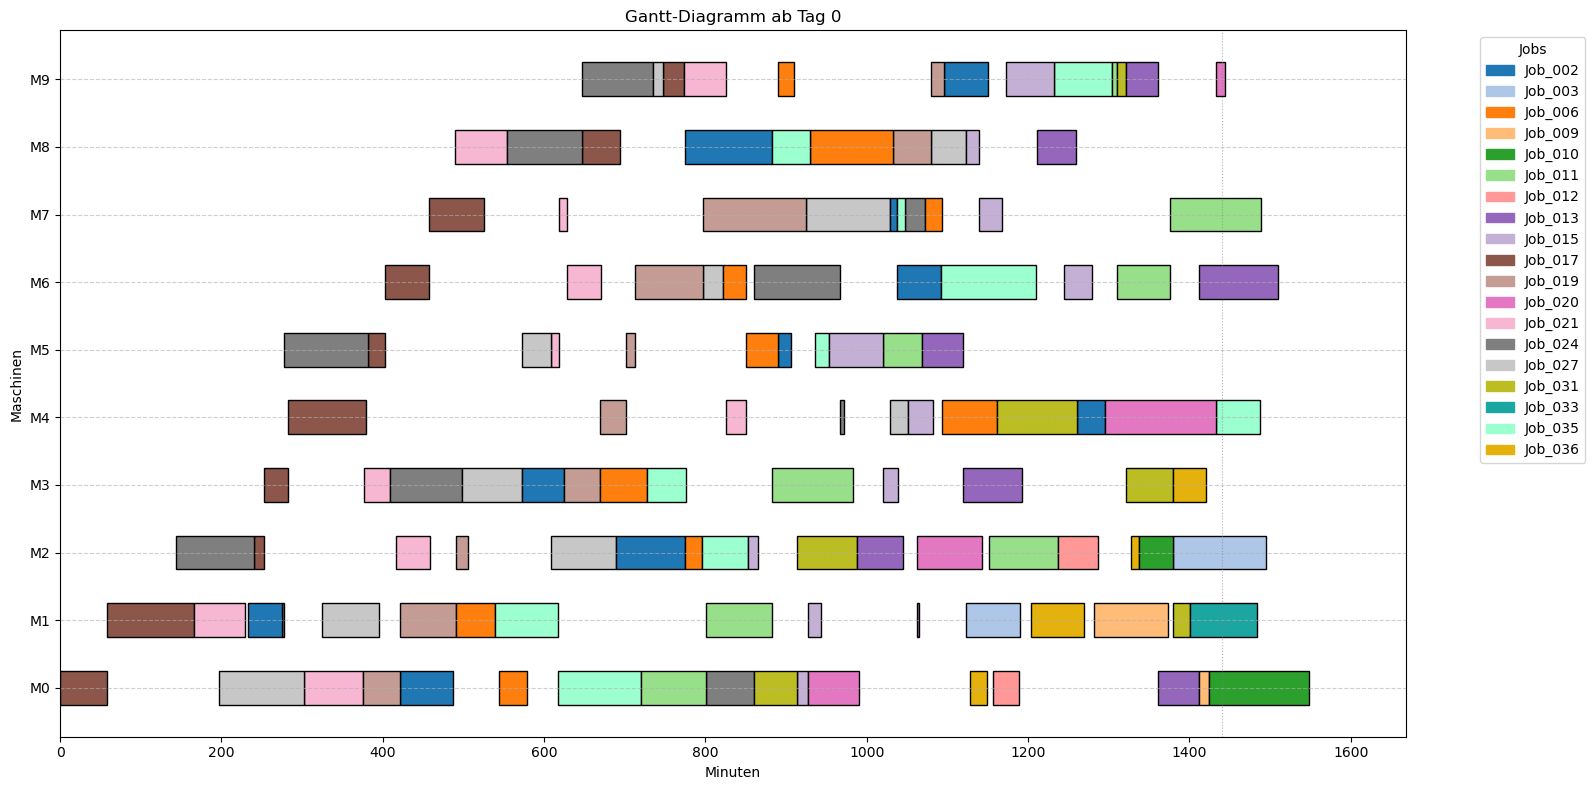

In [20]:
if not df_execution.empty:
    show.plot_gantt_machines(df_execution, title=f"Gantt-Diagramm ab Tag {day_numb}", duration_column="Simulated Processing Time")
else:
    print(f"Nothing executed on day {day_numb}")

### b) Verbleibene Jobs (Rest)

In [22]:
df_rest = df_plan.merge(df_execution[["Job", "Machine"]], on=["Job", "Machine"], how="left", indicator=True)
df_rest = df_rest[df_rest["_merge"] == "left_only"].drop(columns=["_merge"])
df_rest = df_rest.sort_values(by=["Arrival", "Start"]).reset_index(drop=True)
df_rest

,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Tardiness
0,Job_011,8,708,2104,M4,1451,26,1477,-627,0
1,Job_011,9,708,2104,M8,1477,74,1551,-553,0
2,Job_031,6,845,2037,M6,1451,46,1497,-540,0
3,Job_031,7,845,2037,M5,1497,46,1543,-494,0
4,Job_031,8,845,2037,M7,1543,72,1615,-422,0
...,...,...,...,...,...,...,...,...,...,...
246,Job_022,5,2794,4325,M8,3517,52,3569,-756,0
247,Job_022,6,2794,4325,M7,3569,85,3654,-671,0
248,Job_022,7,2794,4325,M3,3654,98,3752,-573,0
249,Job_022,8,2794,4325,M9,3752,22,3774,-551,0


In [23]:
allowed = df_rest["Job"].unique() 
df_time_rest = df_times[df_times["Job"].isin(allowed)].copy()
df_time_rest

,Job,Arrival,Deadline
0,Job_000,2568,3492
1,Job_001,2694,3887
3,Job_003,1123,2654
4,Job_004,2334,3254
5,Job_005,1928,3088
...,...,...,...
32,Job_032,1637,2797
33,Job_033,1354,2885
34,Job_034,1523,2442
36,Job_036,1128,2052


## III) Rescheduling
> vereinfacht, ohne neu Aufträge (nur der Rest)

In [25]:
# Reduktion der bereits ausgeführten Operationen auf die relevanten für die nächsten Tage
df_execution_important = df_execution[df_execution["End"] >= 1440]
df_execution_important

,Job,Operation,Arrival,Machine,Start,Simulated Processing Time,Flow time,End
79,Job_035,9,488,M4,1432.93,53.98,998.91,1486.91
87,Job_011,7,708,M7,1375.70,112.46,780.16,1488.16
107,Job_020,3,894,M9,1432.93,11.30,550.23,1444.23
115,Job_013,7,950,M6,1411.92,97.99,559.91,1509.91
117,Job_003,1,1123,M2,1379.83,114.86,371.69,1494.69
127,Job_010,1,1254,M0,1423.65,124.82,294.47,1548.47
128,Job_033,0,1354,M1,1400.49,83.33,129.82,1483.82


In [26]:
from ortools.sat.python import cp_model
import pandas as pd
import math

def solve_cp_jssp_sum_tardiness_with_fixed_ops(df_jssp: pd.DataFrame, df_arrivals_deadlines: pd.DataFrame,
                                               df_executed: pd.DataFrame,
                                               reschedule_start: float = 1440.0,
                                               sort_ascending: bool = False,
                                               msg: bool = False, timeLimit: int = 3600, gapRel: float = 0.0) -> pd.DataFrame:
    model = cp_model.CpModel()

    # === Vorbereitung: Ankunfts- und Deadline-Daten ===
    df_arrivals_deadlines = df_arrivals_deadlines.sort_values("Deadline", ascending=sort_ascending).reset_index(drop=True)
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()
    jobs = df_arrivals_deadlines["Job"].tolist()

    # === Operationen gruppieren und Maschinenmenge bestimmen ===
    ops_grouped = df_jssp.sort_values(["Job", "Operation"]).groupby("Job")
    all_ops, machines = [], set()
    for job in jobs:
        seq = []
        for _, row in ops_grouped.get_group(job).iterrows():
            op_id = int(row["Operation"])
            m = str(row["Machine"])
            d = int(round(row["Processing Time"]))
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    # === Planungshorizont grob schätzen ===
    horizon = int(df_jssp["Processing Time"].sum() + max(deadline.values()))

    # === Feste Operationen auf Maschinen vorbereiten (aus df_executed) ===
    df_executed_fixed = df_executed[df_executed["End"] >= reschedule_start]
    fixed_ops = {
        m: list(grp[["Start", "End"]].itertuples(index=False, name=None))
        for m, grp in df_executed_fixed.groupby("Machine")
    }

    # === Variablen definieren ===
    starts, ends, intervals = {}, {}, {}
    for j, job in enumerate(jobs):
        for o, (op_id, m, d) in enumerate(all_ops[j]):
            suffix = f"{j}_{o}"
            start = model.NewIntVar(0, horizon, f"start_{suffix}")
            end = model.NewIntVar(0, horizon, f"end_{suffix}")
            interval = model.NewIntervalVar(start, d, end, f"interval_{suffix}")
            starts[(j, o)] = start
            ends[(j, o)] = end
            intervals[(j, o)] = (interval, m)

    # === Tardiness-Zielfunktion und Nebenbedingungen je Job ===
    tardiness_vars = []
    for j, job in enumerate(jobs):
        last_op = len(all_ops[j]) - 1
        job_end = ends[(j, last_op)]
        tardiness = model.NewIntVar(0, horizon, f"tardiness_{j}")
        model.Add(tardiness >= job_end - deadline[job])
        tardiness_vars.append(tardiness)

        # Ankunft und Rescheduling
        model.Add(starts[(j, 0)] >= arrival[job])
        model.Add(starts[(j, 0)] >= int(reschedule_start))

        if job in df_executed["Job"].values:
            last_fixed_end = df_executed[df_executed["Job"] == job]["End"].max()
            model.Add(starts[(j, 0)] >= int(math.ceil(last_fixed_end)))

        for o in range(1, len(all_ops[j])):
            model.Add(starts[(j, o)] >= ends[(j, o - 1)])

    # === Maschinenkonflikte (inkl. fixer Intervalle) ===
    for m in machines:
        machine_intervals = [
            interval for (j, o), (interval, mach) in intervals.items() if mach == m
        ]

        for fixed_start, fixed_end in fixed_ops.get(m, []):
            start = math.floor(fixed_start)
            end = math.ceil(fixed_end)
            duration = end - start
            fixed_interval = model.NewIntervalVar(start, duration, end, f"fixed_{m}_{end}")
            machine_intervals.append(fixed_interval)

        model.AddNoOverlap(machine_intervals)

    # === Zielfunktion: Summe aller Tardiness minimieren ===
    model.Minimize(sum(tardiness_vars))

    # === Solver-Konfiguration ===
    solver = cp_model.CpSolver()
    solver.parameters.log_search_progress = msg
    solver.parameters.relative_gap_limit = gapRel
    solver.parameters.max_time_in_seconds = timeLimit
    status = solver.Solve(model)

    # === Lösung extrahieren ===
    records = []
    if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
        for j, job in enumerate(jobs):
            for o, (op_id, m, d) in enumerate(all_ops[j]):
                st = solver.Value(starts[(j, o)])
                ed = st + d
                lateness = ed - deadline[job]
                records.append({
                    "Job": job,
                    "Operation": op_id,
                    "Arrival": arrival[job],
                    "Deadline": deadline[job],
                    "Machine": m,
                    "Start": st,
                    "Processing Time": d,
                    "End": ed,
                    "Lateness": lateness,
                    "Tardiness": max(0, lateness)
                })

        df_schedule = pd.DataFrame.from_records(records).sort_values(by=["Start", "Arrival"]).reset_index(drop=True)
    else:
        print("No solution was found within the time limit!")
        df_schedule = pd.DataFrame()

    # === Logging ===
    print(f"\nSolver-Status         : {solver.StatusName(status)}")
    print(f"Summe Tardiness       : {solver.ObjectiveValue()}")
    print(f"Best Objective Bound  : {solver.BestObjectiveBound()}")
    print(f"Laufzeit              : {solver.WallTime():.2f} Sekunden")

    return df_schedule


In [27]:
starting_time = time.time()
df_reschedule = solve_cp_jssp_sum_tardiness_with_fixed_ops(df_rest, df_time_rest, df_execution_important,
                                                           reschedule_start = 1440, msg=False, timeLimit=max_time, gapRel= 0)
# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_reschedule


Solver-Status         : OPTIMAL
Summe Tardiness       : 0.0
Best Objective Bound  : 0.0
Laufzeit              : 0.53 Sekunden

Scheduling-Dauer: 0 Minuten und 0.69 Sekunden.


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Tardiness
0,Job_020,4,894,2087,M3,1445,69,1514,-573,0
1,Job_014,0,1440,2971,M1,1484,81,1565,-1406,0
2,Job_036,4,1128,2052,M4,1487,49,1536,-516,0
3,Job_009,2,1134,2397,M2,1495,61,1556,-841,0
4,Job_031,6,845,2037,M6,1510,46,1556,-481,0
...,...,...,...,...,...,...,...,...,...,...
246,Job_001,9,2694,3887,M8,3581,30,3611,-276,0
247,Job_022,6,2794,4325,M7,3598,85,3683,-642,0
248,Job_022,7,2794,4325,M3,3683,98,3781,-544,0
249,Job_022,8,2794,4325,M9,3781,22,3803,-522,0


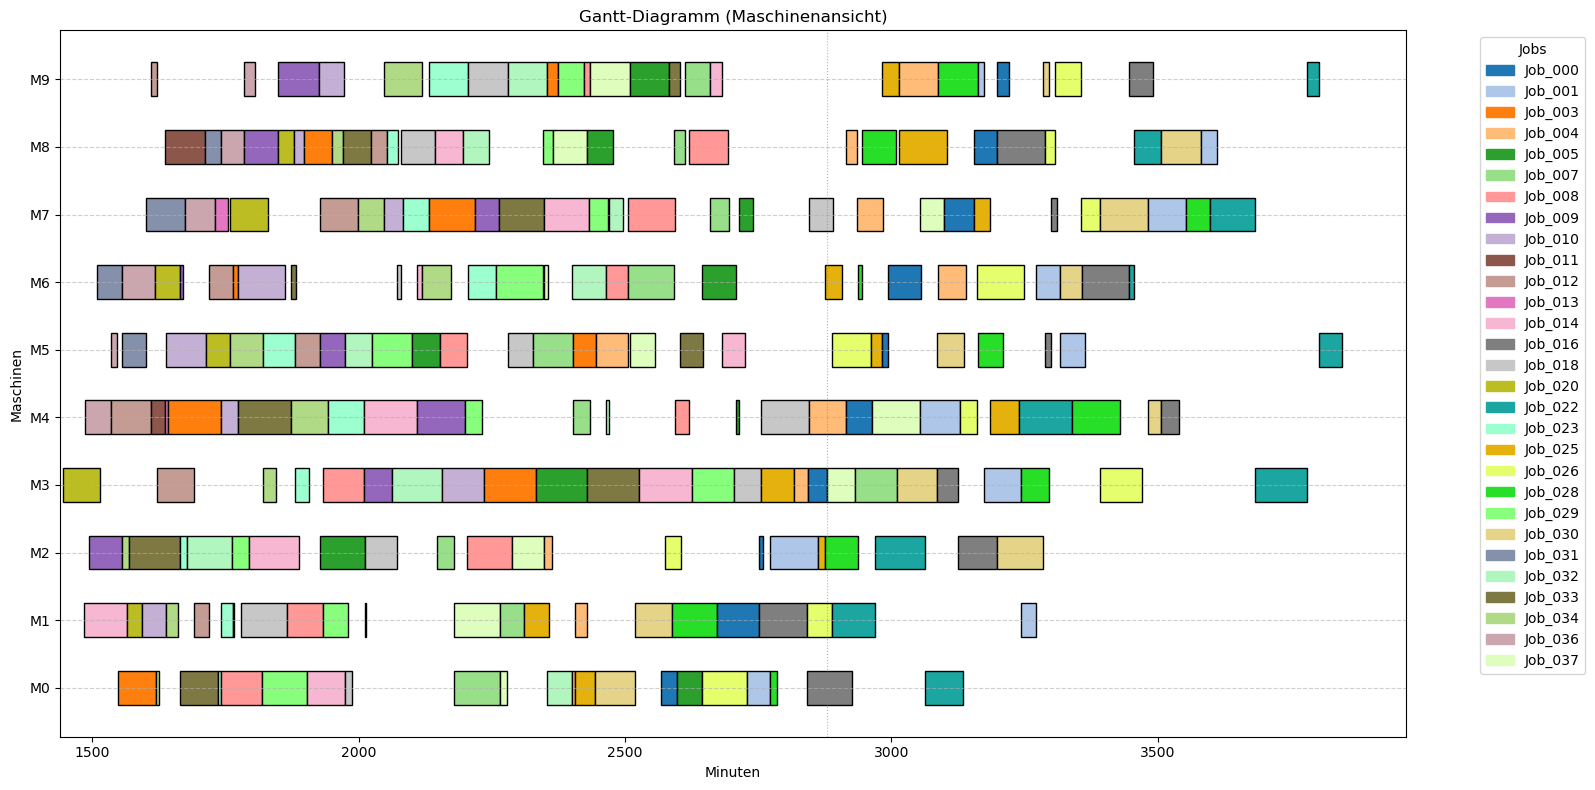

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job


True

In [28]:
show.plot_gantt_machines(df_reschedule)
check.is_machine_conflict_free(df_reschedule)
check.is_operation_sequence_correct(df_reschedule)
check.is_job_timing_correct(df_reschedule)
check.is_start_correct(df_reschedule)

In [63]:
last_ops = df_reschedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
show.count_column_grouped(last_ops, "Lateness", min_val = -360, max_val = 0, steps= 30)

label
<-360          5
-360 - -330    4
-330 - -300    1
-300 - -270    5
-270 - -240    4
-240 - -210    3
-210 - -180    3
-180 - -150    1
-150 - -120    1
-120 - -90     1
-90 - -60      0
-60 - -30      0
-30 - 0        1
0              0
>0             0
Name: count, dtype: int32

### Combi aus Simulation und Neuplannung

In [31]:
# Relevante Spalten
columns_needed = ["Job", "Operation", "Arrival", "Machine", "Start", "Processing Time", "End"]

# Spalte in df_execution umbenennen
df_execution_important_renamed = df_execution.rename(columns={"Simulated Processing Time": "Processing Time"})

# Auf die gewünschten Spalten beschränken
df_exec_trimmed = df_execution_important_renamed[columns_needed]
df_resched_trimmed = df_reschedule[columns_needed]

# DataFrames zusammenführen
df_combined = pd.concat([df_exec_trimmed, df_resched_trimmed], ignore_index=True)
df_combined

,Job,Operation,Arrival,Machine,Start,Processing Time,End
0,Job_017,0,0,M0,0.00,58.68,58.68
1,Job_017,1,0,M1,58.68,107.22,165.90
2,Job_017,2,0,M2,239.71,13.39,253.10
3,Job_017,3,0,M3,253.10,29.78,282.88
4,Job_017,4,0,M4,282.88,96.68,379.56
...,...,...,...,...,...,...,...
375,Job_001,9,2694,M8,3581.00,30.00,3611.00
376,Job_022,6,2794,M7,3598.00,85.00,3683.00
377,Job_022,7,2794,M3,3683.00,98.00,3781.00
378,Job_022,8,2794,M9,3781.00,22.00,3803.00


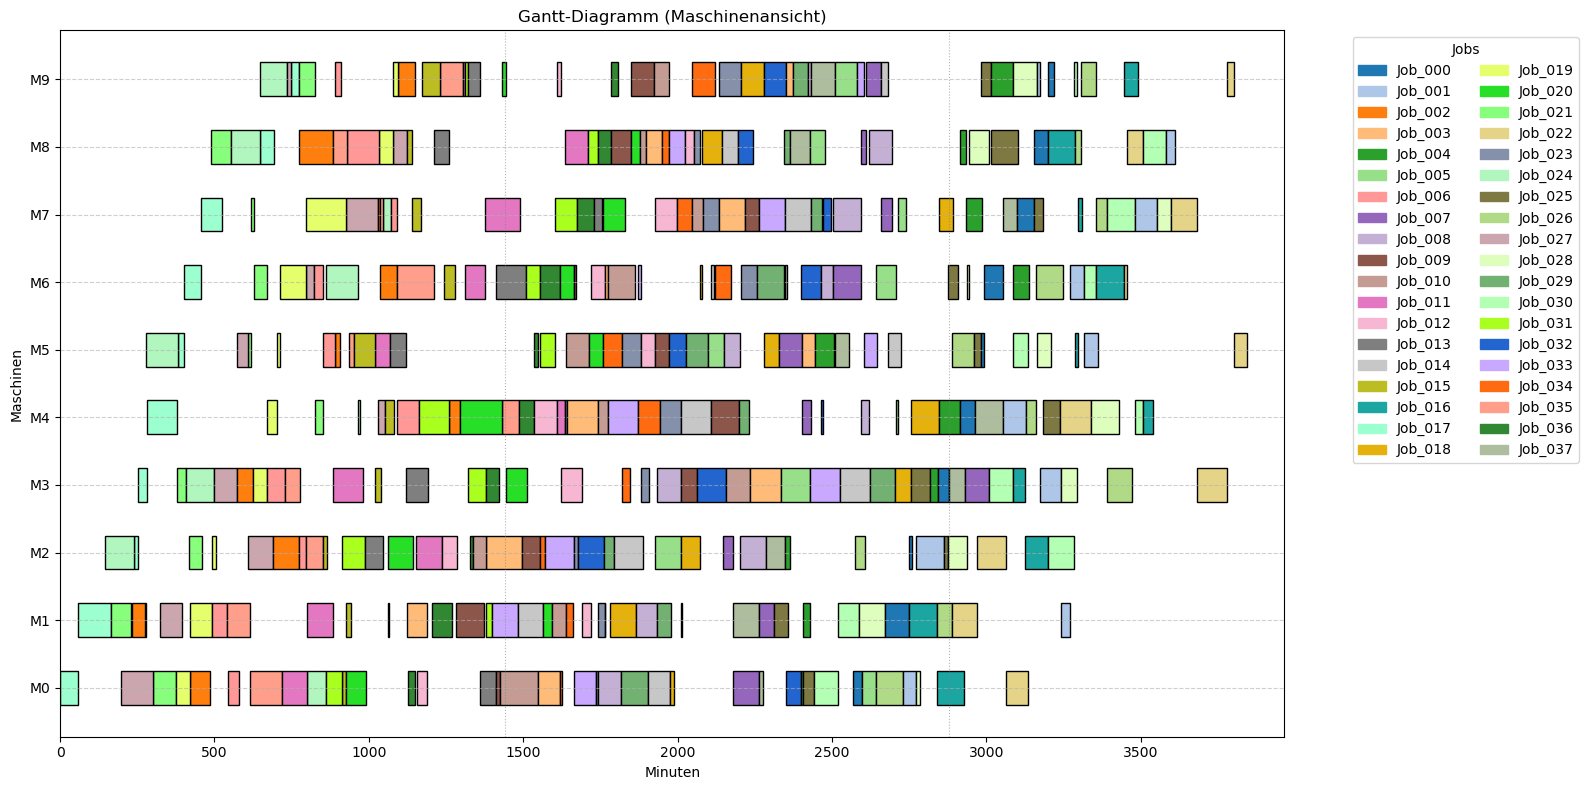

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job


True

In [32]:
show.plot_gantt_machines(df_combined)
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)